In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 12.3 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824028 sha256=23504ee5b56277c5d266f17f9eb4b486d542e2755ff7319df44cab8483c07223
  Stored in directory: /root/.cache/pip/wheels/6c/e3/9b/0525ce8a69478916513509d43693511463c6468db0de237c86
Successfully built pyspark
  Attempting uninstall: py4j
    Found existing installation: py4j 0.10.9.7
    Uninstalling py4j-0.10.9.7:
      Successfully uninstalled py4j-0.10.9.7


In [2]:
from pyspark import SparkConf, SparkContext

In [3]:
## Deneme Amaçlı Spark ın Çalışıp Çalışmadığını  bir  görmüş olalm.
conf = SparkConf().setMaster("local").setAppName("MinTemperatures")
sc = SparkContext(conf = conf)

def parseLine(line):
    fields = line.split(',')
    stationID = fields[0]
    entryType = fields[2]
    temperature = float(fields[3]) * 0.1 * (9.0 / 5.0) + 32.0
    return (stationID, entryType, temperature)

lines = sc.textFile("1800.csv")
parsedLines = lines.map(parseLine)
minTemps = parsedLines.filter(lambda x: "TMIN" in x[1])
stationTemps = minTemps.map(lambda x: (x[0], x[2]))
minTemps = stationTemps.reduceByKey(lambda x, y: min(x,y))
results = minTemps.collect();

for result in results:
  print(result[0] + "\t{:.2f}F".format(result[1]))

sc.stop()

ITE00100554	5.36F
EZE00100082	7.70F


In [4]:
pip install findspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.conf import SparkConf

spark=SparkSession.builder\
    .master("local")\
    .appName("spark_with_churn_analysis")\
    .config("spark.executer.memory","128gb")\
    .getOrCreate()
sc=spark.sparkContext

In [6]:
spark_df=spark.read.csv("churn.csv",header=True,sep=",",inferSchema=True)
spark_df.cache()

DataFrame[_c0: int, Names: string, Age: double, Total_Purchase: double, Account_Manager: int, Years: double, Num_Sites: double, Churn: int]

In [7]:
spark_df.show(2)

+---+----------------+----+--------------+---------------+-----+---------+-----+
|_c0|           Names| Age|Total_Purchase|Account_Manager|Years|Num_Sites|Churn|
+---+----------------+----+--------------+---------------+-----+---------+-----+
|  0|Cameron Williams|42.0|       11066.8|              0| 7.22|      8.0|    1|
|  1|   Kevin Mueller|41.0|      11916.22|              0|  6.5|     11.0|    1|
+---+----------------+----+--------------+---------------+-----+---------+-----+
only showing top 2 rows



In [8]:
spark_df.count()

900

In [9]:
len(spark_df.columns)

8

In [10]:
spark_df.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- Names: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- Total_Purchase: double (nullable = true)
 |-- Account_Manager: integer (nullable = true)
 |-- Years: double (nullable = true)
 |-- Num_Sites: double (nullable = true)
 |-- Churn: integer (nullable = true)



In [11]:
spark_df=spark_df.withColumnRenamed("_c0","index")

In [12]:
# tüm column'lar küçük harfe çevrildi
spark_df=spark_df.toDF(*[c.lower() for c in spark_df.columns])

In [13]:
spark_df.printSchema()

root
 |-- index: integer (nullable = true)
 |-- names: string (nullable = true)
 |-- age: double (nullable = true)
 |-- total_purchase: double (nullable = true)
 |-- account_manager: integer (nullable = true)
 |-- years: double (nullable = true)
 |-- num_sites: double (nullable = true)
 |-- churn: integer (nullable = true)



In [14]:
#Duplicate Veri var mı? Kontrol Ediyoruz.
spark_df.distinct().count()

900

In [15]:
#isim olarak aynı olanlar var mı?
spark_df.select("names").distinct().count()
# iki tane aynı isimden var

899

In [16]:
spark_df.groupBy("names").count().sort("count",ascending=False).show(3)

+-------------+-----+
|        names|count|
+-------------+-----+
|Jennifer Wood|    2|
| Patrick Bell|    1|
|Chelsea Marsh|    1|
+-------------+-----+
only showing top 3 rows



In [17]:
#Jennifer Wood isim benzerliği mi yoksa aynı kişi mi?
spark_df.filter(spark_df.names=="Jennifer Wood").show()
#farklı kişiler

+-----+-------------+----+--------------+---------------+-----+---------+-----+
|index|        names| age|total_purchase|account_manager|years|num_sites|churn|
+-----+-------------+----+--------------+---------------+-----+---------+-----+
|   22|Jennifer Wood|35.0|       9381.12|              1| 6.78|     11.0|    1|
|  439|Jennifer Wood|48.0|      11585.16|              0| 4.61|      9.0|    0|
+-----+-------------+----+--------------+---------------+-----+---------+-----+



In [18]:
#farklı kişi değil de aynı kişi olsaydı kaldırmak için , duplicate kayıların silmek için tekilleştirmek iin
spark_df.select("names").dropDuplicates().groupBy("names").count().sort("count",ascending=False).show(3)

+----------------+-----+
|           names|count|
+----------------+-----+
|    Patrick Bell|    1|
|Patrick Robinson|    1|
|   Chelsea Marsh|    1|
+----------------+-----+
only showing top 3 rows



In [19]:
# istenilen index e erişmek için
spark_df.where(spark_df.index==439).show()

+-----+-------------+----+--------------+---------------+-----+---------+-----+
|index|        names| age|total_purchase|account_manager|years|num_sites|churn|
+-----+-------------+----+--------------+---------------+-----+---------+-----+
|  439|Jennifer Wood|48.0|      11585.16|              0| 4.61|      9.0|    0|
+-----+-------------+----+--------------+---------------+-----+---------+-----+



In [20]:
spark_df.where(spark_df.names=="Patrick Robinson").show()
#spark_df.filter(spark_df.names=="Patrick Robinson").show()

+-----+----------------+----+--------------+---------------+-----+---------+-----+
|index|           names| age|total_purchase|account_manager|years|num_sites|churn|
+-----+----------------+----+--------------+---------------+-----+---------+-----+
|   85|Patrick Robinson|47.0|        7396.1|              0| 4.11|     11.0|    1|
+-----+----------------+----+--------------+---------------+-----+---------+-----+



In [21]:
#birşeyi string olarak yakalamak için Örnek olarak Jennifer Wood elde etmek için
spark_df.where(spark_df.index==439).select("names").show()

+-------------+
|        names|
+-------------+
|Jennifer Wood|
+-------------+



In [22]:
spark_df.where(spark_df.index==439).collect()[0]["names"]

'Jennifer Wood'

In [23]:
spark_df.describe().show()

+-------+------------------+-------------+-----------------+-----------------+------------------+-----------------+------------------+-------------------+
|summary|             index|        names|              age|   total_purchase|   account_manager|            years|         num_sites|              churn|
+-------+------------------+-------------+-----------------+-----------------+------------------+-----------------+------------------+-------------------+
|  count|               900|          900|              900|              900|               900|              900|               900|                900|
|   mean|             449.5|         null|41.81666666666667|10062.82403333334|0.4811111111111111| 5.27315555555555| 8.587777777777777|0.16666666666666666|
| stddev|259.95191863111916|         null|6.127560416916251|2408.644531858096|0.4999208935073339|1.274449013194616|1.7648355920350969| 0.3728852122772358|
|    min|                 0|   Aaron King|             22.0|          

In [24]:
spark_df.columns

['index',
 'names',
 'age',
 'total_purchase',
 'account_manager',
 'years',
 'num_sites',
 'churn']

In [25]:
spark_df.select('age','total_purchase','account_manager','years','num_sites','churn').describe().show()

+-------+-----------------+-----------------+------------------+-----------------+------------------+-------------------+
|summary|              age|   total_purchase|   account_manager|            years|         num_sites|              churn|
+-------+-----------------+-----------------+------------------+-----------------+------------------+-------------------+
|  count|              900|              900|               900|              900|               900|                900|
|   mean|41.81666666666667|10062.82403333334|0.4811111111111111| 5.27315555555555| 8.587777777777777|0.16666666666666666|
| stddev|6.127560416916251|2408.644531858096|0.4999208935073339|1.274449013194616|1.7648355920350969| 0.3728852122772358|
|    min|             22.0|            100.0|                 0|              1.0|               3.0|                  0|
|    max|             65.0|         18026.01|                 1|             9.15|              14.0|                  1|
+-------+---------------

In [26]:
##Denormalize bir şekilde veriyi göstermek için transpose
spark_df.describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
index,900,449.5,259.95191863111916,0,899
names,900,None,None,Aaron King,Zachary Walsh
age,900,41.81666666666667,6.127560416916251,22.0,65.0
total_purchase,900,10062.82403333334,2408.644531858096,100.0,18026.01
account_manager,900,0.4811111111111111,0.4999208935073339,0,1
years,900,5.27315555555555,1.274449013194616,1.0,9.15
num_sites,900,8.587777777777777,1.7648355920350969,3.0,14.0
churn,900,0.16666666666666666,0.3728852122772358,0,1


In [27]:
import seaborn as sns

In [29]:
##İhtiyacmız olmayan kaolonların kaldırıyoruz.
pandas_df=spark_df.drop("index","names").toPandas()

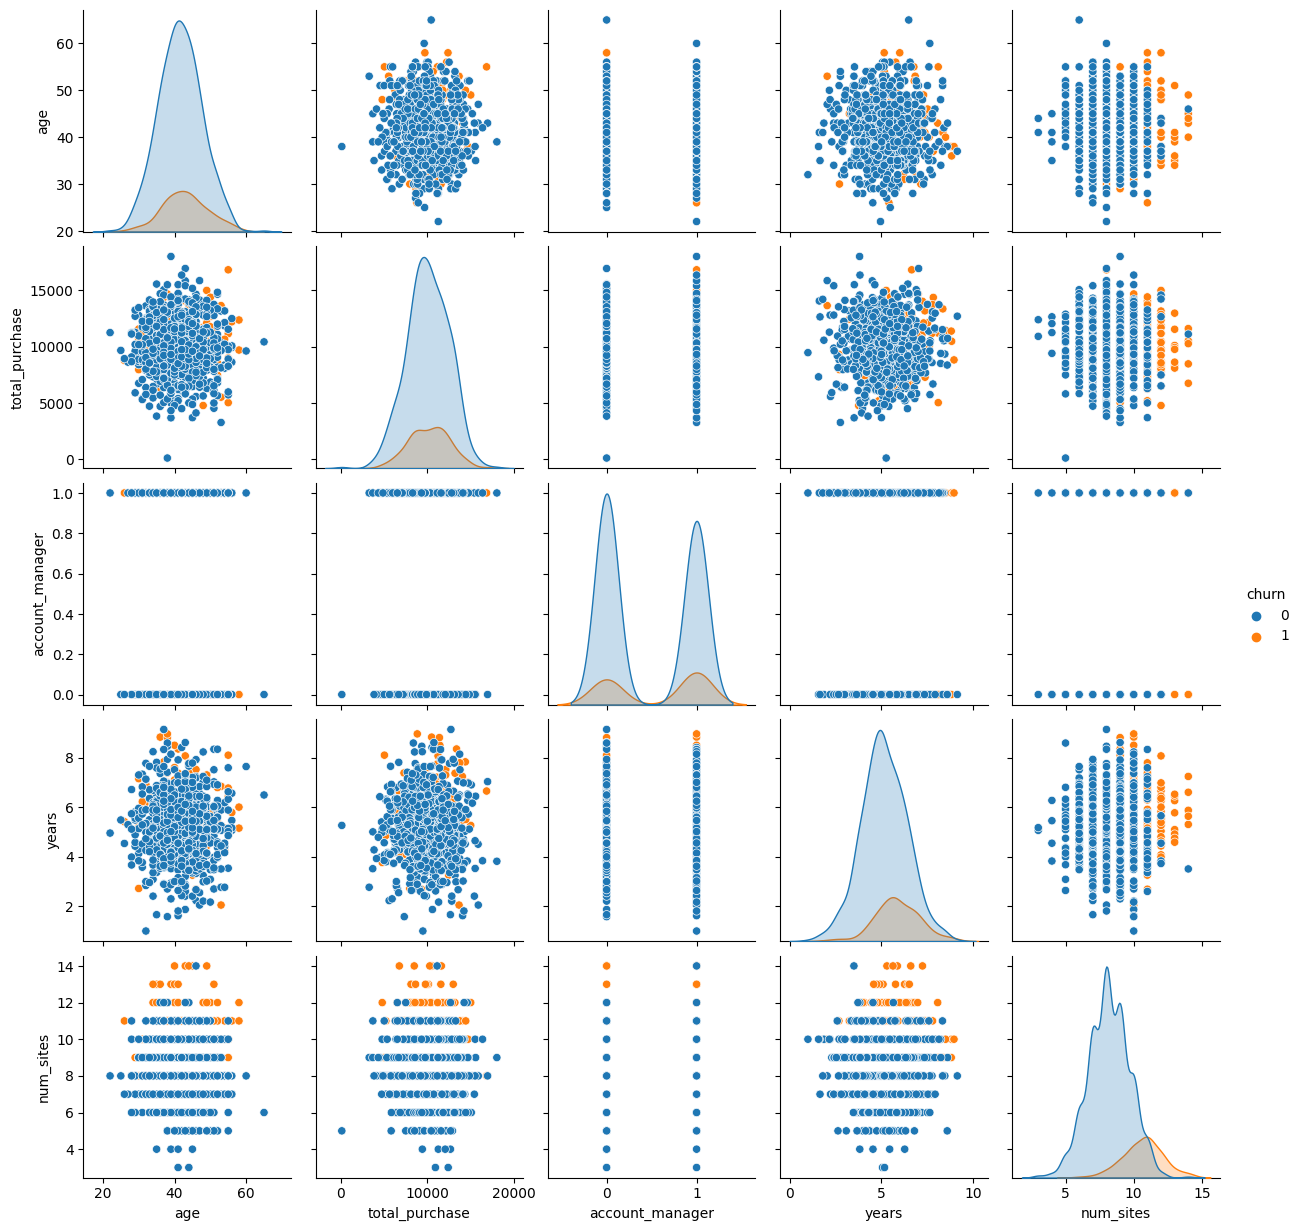

In [30]:
##PairPlot ile Churn Kolonuna göre diğer Kolonların Kombinasyonları
sns.pairplot(pandas_df,hue="churn");

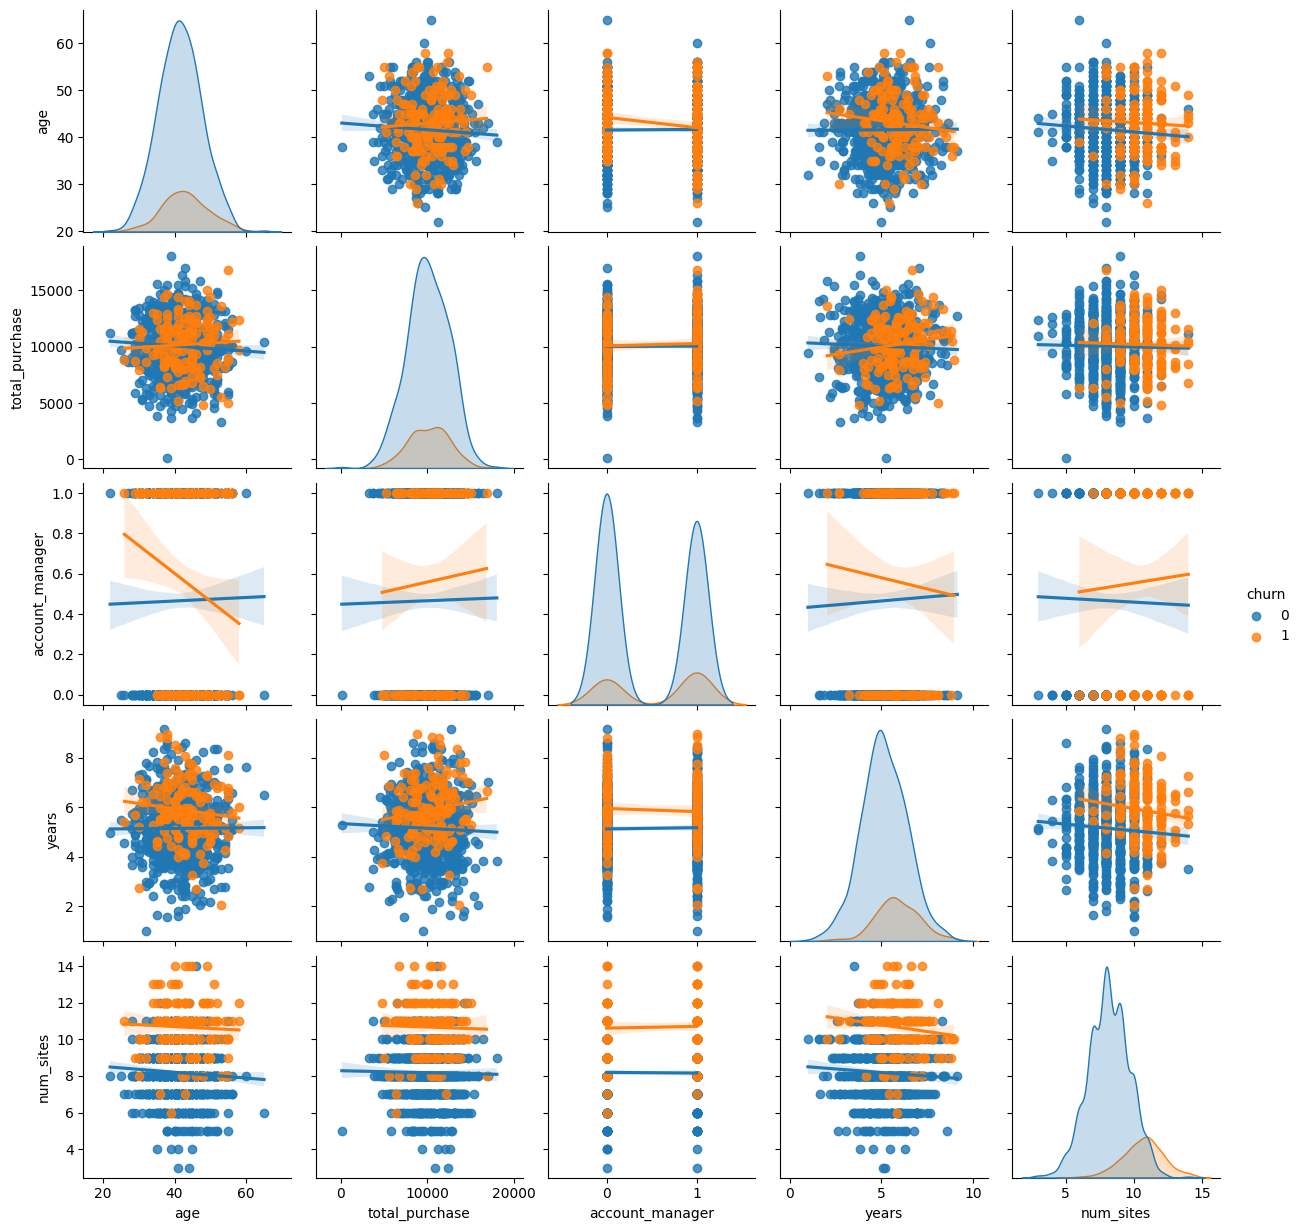

In [31]:
sns.pairplot(pandas_df,hue="churn",kind="reg");

In [32]:
##Na olan Kayıtları Temizliyoruz.
spark_df=spark_df.dropna()

In [34]:
## Önemli Olan Kolonun Karesi ile Yeni bir Kolonda Hesaplıyoruz.
spark_df=spark_df.withColumn("age_sqrt",spark_df.age**2)

In [35]:
spark_df.show(3)

+-----+----------------+----+--------------+---------------+-----+---------+-----+--------+
|index|           names| age|total_purchase|account_manager|years|num_sites|churn|age_sqrt|
+-----+----------------+----+--------------+---------------+-----+---------+-----+--------+
|    0|Cameron Williams|42.0|       11066.8|              0| 7.22|      8.0|    1|  1764.0|
|    1|   Kevin Mueller|41.0|      11916.22|              0|  6.5|     11.0|    1|  1681.0|
|    2|     Eric Lozano|38.0|      12884.75|              0| 6.67|     12.0|    1|  1444.0|
+-----+----------------+----+--------------+---------------+-----+---------+-----+--------+
only showing top 3 rows



In [36]:
from pyspark.ml.feature import StringIndexer
stringIndexer=StringIndexer(inputCol="churn",outputCol="label")

In [37]:
indexed=stringIndexer.fit(spark_df).transform(spark_df)

In [38]:
indexed.dtypes

[('index', 'int'),
 ('names', 'string'),
 ('age', 'double'),
 ('total_purchase', 'double'),
 ('account_manager', 'int'),
 ('years', 'double'),
 ('num_sites', 'double'),
 ('churn', 'int'),
 ('age_sqrt', 'double'),
 ('label', 'double')]

In [39]:
spark_df.show(3)

+-----+----------------+----+--------------+---------------+-----+---------+-----+--------+
|index|           names| age|total_purchase|account_manager|years|num_sites|churn|age_sqrt|
+-----+----------------+----+--------------+---------------+-----+---------+-----+--------+
|    0|Cameron Williams|42.0|       11066.8|              0| 7.22|      8.0|    1|  1764.0|
|    1|   Kevin Mueller|41.0|      11916.22|              0|  6.5|     11.0|    1|  1681.0|
|    2|     Eric Lozano|38.0|      12884.75|              0| 6.67|     12.0|    1|  1444.0|
+-----+----------------+----+--------------+---------------+-----+---------+-----+--------+
only showing top 3 rows



In [40]:
spark_df=indexed.withColumn("label",indexed.label.cast("integer"))

In [41]:
spark_df.dtypes

[('index', 'int'),
 ('names', 'string'),
 ('age', 'double'),
 ('total_purchase', 'double'),
 ('account_manager', 'int'),
 ('years', 'double'),
 ('num_sites', 'double'),
 ('churn', 'int'),
 ('age_sqrt', 'double'),
 ('label', 'int')]

In [42]:
from pyspark.ml.feature import VectorAssembler
bag_deg=['age','total_purchase','account_manager','years','num_sites']

In [43]:
vectorAssembler=VectorAssembler(inputCols=bag_deg,outputCol="features")

In [44]:
features_deg=vectorAssembler.transform(spark_df)

In [45]:
final_df=features_deg.select("features","label")
final_df.show()

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[42.0,11066.8,0.0...|    1|
|[41.0,11916.22,0....|    1|
|[38.0,12884.75,0....|    1|
|[42.0,8010.76,0.0...|    1|
|[37.0,9191.58,0.0...|    1|
|[48.0,10356.02,0....|    1|
|[44.0,11331.58,1....|    1|
|[32.0,9885.12,1.0...|    1|
|[43.0,14062.6,1.0...|    1|
|[40.0,8066.94,1.0...|    1|
|[30.0,11575.37,1....|    1|
|[45.0,8771.02,1.0...|    1|
|[45.0,8988.67,1.0...|    1|
|[40.0,8283.32,1.0...|    1|
|[41.0,6569.87,1.0...|    1|
|[38.0,10494.82,1....|    1|
|[45.0,8213.41,1.0...|    1|
|[43.0,11226.88,0....|    1|
|[53.0,5515.09,0.0...|    1|
|[46.0,8046.4,1.0,...|    1|
+--------------------+-----+
only showing top 20 rows



In [46]:
final_df.printSchema()

root
 |-- features: vector (nullable = true)
 |-- label: integer (nullable = true)



In [47]:
splits=final_df.randomSplit([0.7,0.3])

In [48]:
train_df=splits[0]
test_df=splits[1]

In [49]:
train_df.count(),test_df.count()

(638, 262)

In [ ]:
## Modeling 

In [50]:
from pyspark.ml.classification import GBTClassifier

In [51]:
gbm=GBTClassifier(maxIter=10,featuresCol="features",labelCol="label")

In [52]:
gbm_model=gbm.fit(train_df)

In [53]:
y_pred=gbm_model.transform(test_df)

In [54]:
y_pred.show(2)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[22.0,11254.38,1....|    0|[1.03179491522214...|[0.88731360987183...|       0.0|
|[26.0,8787.39,1.0...|    1|[0.58063051620773...|[0.76156177548842...|       0.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 2 rows



In [55]:
ac=y_pred.select("label","prediction")
ac.show(3)

+-----+----------+
|label|prediction|
+-----+----------+
|    0|       0.0|
|    1|       0.0|
|    0|       0.0|
+-----+----------+
only showing top 3 rows



In [56]:
ac.filter(ac.label==ac.prediction).count()/ac.count()

0.8893129770992366

In [57]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder,CrossValidator

In [58]:
evaluator=BinaryClassificationEvaluator()
pramGrid=(ParamGridBuilder()
         .addGrid(gbm.maxDepth,[2,4,6])
         .addGrid(gbm.maxBins,[20,30])
         .addGrid(gbm.maxIter,[10,20])
         .build())

cv=CrossValidator(estimator=gbm,estimatorParamMaps=pramGrid,evaluator=evaluator,numFolds=10)

In [59]:
cv_model=cv.fit(train_df)
y_pred=cv_model.transform(test_df)

In [60]:
y_pred.show(2)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[22.0,11254.38,1....|    0|[1.39004350725753...|[0.94159023027175...|       0.0|
|[26.0,8787.39,1.0...|    1|[-0.2449043716909...|[0.37993862386343...|       1.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 2 rows



In [61]:
ac=y_pred.select("label","prediction")

In [62]:
ac.filter(ac.label==ac.prediction).count()/ac.count()

0.9122137404580153

In [63]:
evaluator.evaluate(y_pred)

0.92109500805153

In [ ]:
## Modelimizin Çalışıp Çalışmadığının Testini Yapalım.

In [64]:
import pandas as pd

In [71]:
client_df=pd.read_csv("churn_for_example.csv", sep = ';')

In [73]:
client_df

,names,age,total_purchase,account_manager,years,num_sites
0,Mehmet Duruer,39,80000,1,15,35
1,Recep Abic,35,5500,0,3,30
2,Ahmet Selim,11,8500,0,0,2
3,Hasan Doğan,29,5000,1,3,12


In [72]:
client_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   names            4 non-null      object
 1   age              4 non-null      int64 
 2   total_purchase   4 non-null      int64 
 3   account_manager  4 non-null      int64 
 4   years            4 non-null      int64 
 5   num_sites        4 non-null      int64 
dtypes: int64(5), object(1)
memory usage: 320.0+ bytes


In [74]:
client_spark=spark.createDataFrame(client_df)

In [75]:
client_spark.show()

+-------------+---+--------------+---------------+-----+---------+
|        names|age|total_purchase|account_manager|years|num_sites|
+-------------+---+--------------+---------------+-----+---------+
|Mehmet Duruer| 39|         80000|              1|   15|       35|
|   Recep Abic| 35|          5500|              0|    3|       30|
|  Ahmet Selim| 11|          8500|              0|    0|        2|
|  Hasan Doğan| 29|          5000|              1|    3|       12|
+-------------+---+--------------+---------------+-----+---------+



In [76]:
client_vector=vectorAssembler.transform(client_spark)

In [77]:
client_vector.show()

+-------------+---+--------------+---------------+-----+---------+--------------------+
|        names|age|total_purchase|account_manager|years|num_sites|            features|
+-------------+---+--------------+---------------+-----+---------+--------------------+
|Mehmet Duruer| 39|         80000|              1|   15|       35|[39.0,80000.0,1.0...|
|   Recep Abic| 35|          5500|              0|    3|       30|[35.0,5500.0,0.0,...|
|  Ahmet Selim| 11|          8500|              0|    0|        2|[11.0,8500.0,0.0,...|
|  Hasan Doğan| 29|          5000|              1|    3|       12|[29.0,5000.0,1.0,...|
+-------------+---+--------------+---------------+-----+---------+--------------------+



In [78]:
results=cv_model.transform(client_vector)
results.select("names","prediction").show()

+-------------+----------+
|        names|prediction|
+-------------+----------+
|Mehmet Duruer|       1.0|
|   Recep Abic|       0.0|
|  Ahmet Selim|       0.0|
|  Hasan Doğan|       0.0|
+-------------+----------+

